<a href="https://www.kaggle.com/code/andrewbremner/weightrisk-s4e2-sklearn-models-vs-pytorch?scriptVersionId=163627553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# Explore Data

In [3]:
# No missing data
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [4]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# df = df[['id', 'Age', 'Height', 'Weight',
#        'family_history_with_overweight', 'FAVC', 'FCVC',
#        'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'NObeyesdad']]

### Check balance of data set

<Axes: xlabel='NObeyesdad', ylabel='count'>

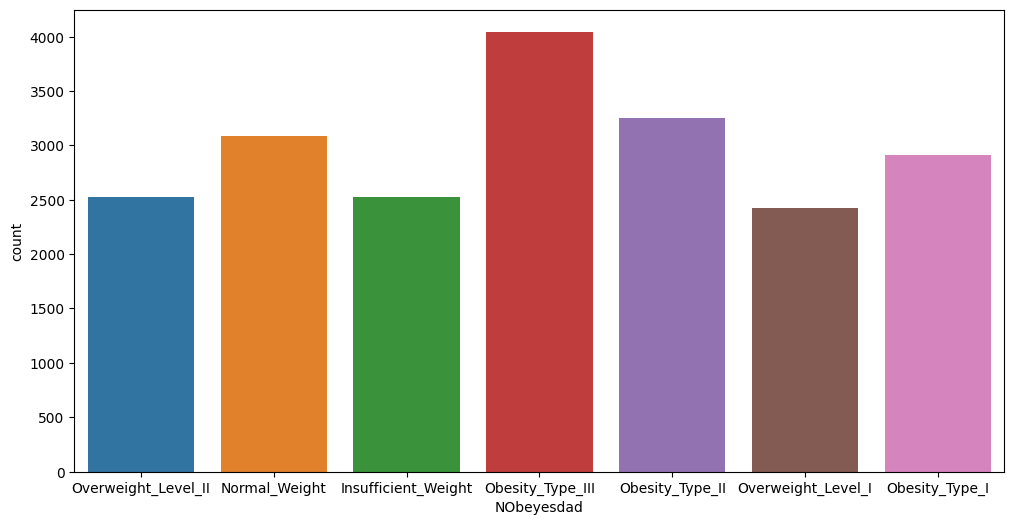

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='NObeyesdad')

### Pretty balenced dataset with a little larger weight to the higher obersity type III

In [7]:
catagorical_cols = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
target_options = df['NObeyesdad'].unique()
ids = df['id']

### Cleaning data function (to dummy variables)
Make new column for BMI

In [8]:
def process_data_dummies(df):
    df = df.drop(['id'], axis=1)
    df = pd.get_dummies(df, drop_first=True)
    df['BMI'] = df['Weight'] /(df['Height']**2)
    return df

In [9]:
#Shuffle
df = df.sample(frac = 1)
df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
3199,3199,Female,22.000000,1.560000,45.000000,yes,yes,3.000000,3.0,Always,no,2.000000,no,2.000000,1.000000,no,Public_Transportation,Normal_Weight
19074,19074,Female,22.000000,1.640000,82.000000,yes,yes,1.000000,1.0,Sometimes,no,2.000000,no,0.000000,2.000000,Sometimes,Public_Transportation,Obesity_Type_I
8669,8669,Female,21.289104,1.738717,127.161381,yes,yes,3.000000,3.0,Sometimes,no,1.693362,no,1.946907,0.946888,Sometimes,Public_Transportation,Obesity_Type_III
18471,18471,Female,26.000000,1.637725,111.930700,yes,yes,3.000000,3.0,Sometimes,no,2.770125,no,0.000000,0.451377,Sometimes,Public_Transportation,Obesity_Type_III
18077,18077,Male,33.000000,1.800000,97.000000,yes,yes,2.000000,3.0,Sometimes,no,3.000000,no,1.000000,0.000000,Frequently,Automobile,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15263,15263,Male,23.884212,1.773664,116.160329,yes,yes,1.754401,3.0,Sometimes,no,2.000000,no,1.399183,0.632467,Sometimes,Public_Transportation,Obesity_Type_II
2730,2730,Male,18.000000,1.820000,70.000000,yes,yes,2.000000,3.0,Always,no,2.000000,no,3.000000,0.000000,no,Public_Transportation,Normal_Weight
3950,3950,Female,21.000000,1.520000,42.000000,yes,yes,3.000000,1.0,Frequently,no,1.000000,no,0.000000,0.000000,no,Public_Transportation,Insufficient_Weight
4178,4178,Male,30.825592,1.708354,130.930448,yes,yes,2.967300,3.0,Sometimes,no,1.946090,no,1.077469,1.000000,Sometimes,Public_Transportation,Obesity_Type_II


In [10]:
# df = df[['id','Height', 'Weight',
#        'family_history_with_overweight', 'NObeyesdad']]

In [11]:
df_drop = df.drop(['NObeyesdad'], axis=1)
df_clean = process_data_dummies(df_drop)

In [12]:
df_clean

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,BMI
3199,22.000000,1.560000,45.000000,3.000000,3.0,2.000000,2.000000,1.000000,False,True,...,False,False,False,False,True,False,False,True,False,18.491124
19074,22.000000,1.640000,82.000000,1.000000,1.0,2.000000,0.000000,2.000000,False,True,...,False,False,False,True,False,False,False,True,False,30.487805
8669,21.289104,1.738717,127.161381,3.000000,3.0,1.693362,1.946907,0.946888,False,True,...,False,False,False,True,False,False,False,True,False,42.062728
18471,26.000000,1.637725,111.930700,3.000000,3.0,2.770125,0.000000,0.451377,False,True,...,False,False,False,True,False,False,False,True,False,41.731814
18077,33.000000,1.800000,97.000000,2.000000,3.0,3.000000,1.000000,0.000000,True,True,...,False,False,False,False,False,False,False,False,False,29.938272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15263,23.884212,1.773664,116.160329,1.754401,3.0,2.000000,1.399183,0.632467,True,True,...,False,False,False,True,False,False,False,True,False,36.924543
2730,18.000000,1.820000,70.000000,2.000000,3.0,2.000000,3.000000,0.000000,True,True,...,False,False,False,False,True,False,False,True,False,21.132713
3950,21.000000,1.520000,42.000000,3.000000,1.0,1.000000,0.000000,0.000000,False,True,...,False,False,False,False,True,False,False,True,False,18.178670
4178,30.825592,1.708354,130.930448,2.967300,3.0,1.946090,1.077469,1.000000,True,True,...,False,False,False,True,False,False,False,True,False,44.862649


In [13]:
# # add BMI (weight (kg) / [height (m)]**2) units are correct
# df_clean['BMI'] = df_clean['Weight'] /(df_clean['Height']**2)

# Visualizations
**Map the string options to numbers for some visualizations**

In [14]:
target_map = {'Insufficient_Weight': 0,
              'Normal_Weight': 1,
              'Overweight_Level_I': 2,
              'Overweight_Level_II': 3,
              'Obesity_Type_I':4,
              'Obesity_Type_II': 5,
              'Obesity_Type_III': 6}
target_map_rev = {0:'Insufficient_Weight',
              1:'Normal_Weight',
              2:'Overweight_Level_I',
              3:'Overweight_Level_II',
              4:'Obesity_Type_I',
              5:'Obesity_Type_II',
              6:'Obesity_Type_III'}

In [15]:
df_clean['NObeyesdad'] = df['NObeyesdad'].map(target_map)

In [16]:
abs(df_clean.corr()['NObeyesdad']).sort_values(ascending=False)[1:]

BMI                                   0.961441
Weight                                0.921250
family_history_with_overweight_yes    0.522026
CAEC_Sometimes                        0.450950
CAEC_Frequently                       0.423351
Age                                   0.356211
CH2O                                  0.273154
FCVC                                  0.272933
CALC_Sometimes                        0.236984
FAF                                   0.234745
CALC_no                               0.226036
FAVC_yes                              0.215401
SCC_yes                               0.184959
Height                                0.150141
TUE                                   0.121009
MTRANS_Walking                        0.119828
CAEC_no                               0.076104
Gender_Male                           0.067699
MTRANS_Public_Transportation          0.062733
MTRANS_Motorbike                      0.028868
MTRANS_Bike                           0.028147
NCP          

### BMI is extremly correlated

<Axes: >

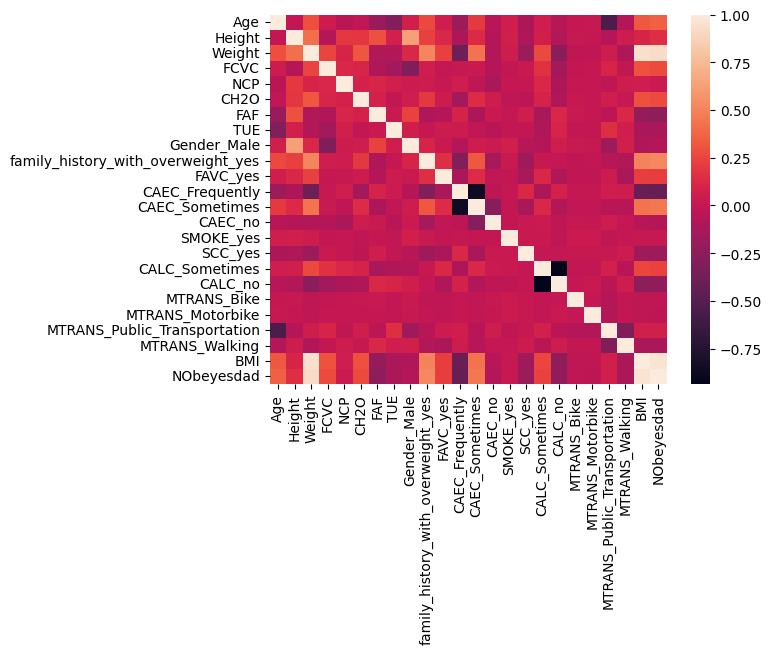

In [17]:
sns.heatmap(data=df_clean.corr())

# Train test split

In [18]:
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
X = df_clean.drop(['NObeyesdad'],axis=1)
y = df['NObeyesdad']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=814)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sci-Kit Learn Model tests

## Random Forest classifier

In [21]:
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
# t1 = time.time()
# rfc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'RFC took {total} s')
# rfc_pred = rfc.predict(X_test_scaled)
# print(f'RFC accuracy {round(accuracy_score(y_test, rfc_pred),8)}')

## Gradient Boosting Classifier 

In [22]:
# gbc = GradientBoostingClassifier(n_estimators=100)
# t1 = time.time()
# gbc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'Final GBC took {total} s')
# gbc_pred = gbc.predict(X_test_scaled)
# print(f'GBC accuracy {round(accuracy_score(y_test, gbc_pred),8)}')

## Hist Gradient Boosting Classifier 

In [23]:
# hgbc = HistGradientBoostingClassifier(class_weight="balanced")
# t1 = time.time()
# hgbc.fit(X_train_scaled, y_train)
# total = time.time() - t1
# print(f'Final HGBC took {total} s')
# hgbc_pred = hgbc.predict(X_test_scaled)
# print(f'HGBC accuracy {round(accuracy_score(y_test, hgbc_pred),8)}')

## XGB Classifier

In [24]:
y_train_nums =  y_train.map(target_map)
y_test_nums =  y_test.map(target_map)

In [25]:
y_train_nums

18249    6
10296    4
9624     6
17415    5
11530    1
        ..
6554     6
9402     3
10799    6
18475    3
5873     6
Name: NObeyesdad, Length: 16606, dtype: int64

In [26]:
xgb = XGBClassifier()
t1 = time.time()
xgb.fit(X_train_scaled, y_train_nums)
total = time.time() - t1
print(f'Final XGB took {total} s')
xgb_pred = xgb.predict(X_test_scaled)
print(f'XGB accuracy {round(accuracy_score(y_test_nums, xgb_pred),8)}')

Final XGB took 2.18669056892395 s
XGB accuracy 0.90101156


# Retrain with all data with best model¶


### Final test data preparation

In [27]:
final_scaler = StandardScaler()
final_scaler.fit(X)
X_scaled = final_scaler.transform(X)
test_ids = df_test['id']
X_Final_test_clean = process_data_dummies(df_test)
X_Final_test_clean = X_Final_test_clean[X.columns] #issue with some data options not existing in train vs test
X_Final_test_clean_scaled = final_scaler.transform(X_Final_test_clean)

In [28]:
# Final Train
# final_model = RandomForestClassifier(n_estimators=100, class_weight="balanced")
# final_model = GradientBoostingClassifier(n_estimators=100)
final_model = XGBClassifier()
y_nums = y.map(target_map)
t1 = time.time()
final_model.fit(X_scaled, y_nums)
total = time.time() - t1
print(f'Final took {total} s')

Final took 2.572871685028076 s


In [29]:
final_preds = final_model.predict(X_Final_test_clean_scaled)
preds_df = pd.DataFrame(final_preds,columns=['NObeyesdad'])
output_df_sk = pd.concat([test_ids,preds_df],axis=1)
output_df_sk['NObeyesdad'] = output_df_sk['NObeyesdad'].map(target_map_rev)
output_df_sk

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [30]:
# output_df_sk.to_csv('/kaggle/working/submission.csv', index=False)

# Neural Network (Pytorch)

In [31]:
df_clean.dtypes

Age                                   float64
Height                                float64
Weight                                float64
FCVC                                  float64
NCP                                   float64
CH2O                                  float64
FAF                                   float64
TUE                                   float64
Gender_Male                              bool
family_history_with_overweight_yes       bool
FAVC_yes                                 bool
CAEC_Frequently                          bool
CAEC_Sometimes                           bool
CAEC_no                                  bool
SMOKE_yes                                bool
SCC_yes                                  bool
CALC_Sometimes                           bool
CALC_no                                  bool
MTRANS_Bike                              bool
MTRANS_Motorbike                         bool
MTRANS_Public_Transportation             bool
MTRANS_Walking                    

In [32]:
df.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [33]:
df_nn = df_clean
df_nn['BMI'] = df_nn['Weight'] /(df_nn['Height']**2)

In [34]:
df_nn

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,BMI,NObeyesdad
3199,22.000000,1.560000,45.000000,3.000000,3.0,2.000000,2.000000,1.000000,False,True,...,False,False,False,True,False,False,True,False,18.491124,1
19074,22.000000,1.640000,82.000000,1.000000,1.0,2.000000,0.000000,2.000000,False,True,...,False,False,True,False,False,False,True,False,30.487805,4
8669,21.289104,1.738717,127.161381,3.000000,3.0,1.693362,1.946907,0.946888,False,True,...,False,False,True,False,False,False,True,False,42.062728,6
18471,26.000000,1.637725,111.930700,3.000000,3.0,2.770125,0.000000,0.451377,False,True,...,False,False,True,False,False,False,True,False,41.731814,6
18077,33.000000,1.800000,97.000000,2.000000,3.0,3.000000,1.000000,0.000000,True,True,...,False,False,False,False,False,False,False,False,29.938272,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15263,23.884212,1.773664,116.160329,1.754401,3.0,2.000000,1.399183,0.632467,True,True,...,False,False,True,False,False,False,True,False,36.924543,5
2730,18.000000,1.820000,70.000000,2.000000,3.0,2.000000,3.000000,0.000000,True,True,...,False,False,False,True,False,False,True,False,21.132713,1
3950,21.000000,1.520000,42.000000,3.000000,1.0,1.000000,0.000000,0.000000,False,True,...,False,False,False,True,False,False,True,False,18.178670,0
4178,30.825592,1.708354,130.930448,2.967300,3.0,1.946090,1.077469,1.000000,True,True,...,False,False,True,False,False,False,True,False,44.862649,5


In [35]:
cont_cols = df_nn.columns
df_nn.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'NObeyesdad'],
      dtype='object')

In [36]:
cont_cols = df_nn.columns #df_nn.describe().columns
# cont_cols = cont_cols.drop(['id'])
cat_cols_obj = df_nn.dtypes[df_nn.dtypes == 'object'].index
cat_cols = cat_cols_obj #.drop('NObeyesdad')
y_col = ['NObeyesdad']

In [37]:
cont_cols, cat_cols

(Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
        'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
        'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
        'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
        'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'NObeyesdad'],
       dtype='object'),
 Index([], dtype='object'))

### Catagorical Data
Leaving as catagories even though they are mostly one hot encoded available

In [38]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [39]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 3199 to 361
Empty DataFrame


In [40]:
# # Convert to numpy array the tensor for NN
# cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
# cats = torch.tensor(cats, dtype=torch.int64)

In [41]:
# cats

### Continuous Data

In [42]:
# Convert to numpy array for NN
conts = np.stack([df_nn[col].values for col in cont_cols[:-1]],axis=1)
conts = torch.tensor(conts, dtype=torch.float)
conts = F.normalize(conts)

In [43]:
conts

tensor([[0.4096, 0.0290, 0.8379,  ..., 0.0186, 0.0000, 0.3443],
        [0.2436, 0.0182, 0.9080,  ..., 0.0111, 0.0000, 0.3376],
        [0.1568, 0.0128, 0.9368,  ..., 0.0074, 0.0000, 0.3099],
        ...,
        [0.4156, 0.0301, 0.8311,  ..., 0.0198, 0.0000, 0.3597],
        [0.2172, 0.0120, 0.9226,  ..., 0.0070, 0.0000, 0.3161],
        [0.3293, 0.0177, 0.8982,  ..., 0.0000, 0.0000, 0.2867]])

## Label

In [44]:
df[y_col[0]].info()

<class 'pandas.core.series.Series'>
Index: 20758 entries, 3199 to 361
Series name: NObeyesdad
Non-Null Count  Dtype 
--------------  ----- 
20758 non-null  object
dtypes: object(1)
memory usage: 324.3+ KB


In [45]:
# set label as catagory
df[y_col[0]] = df[y_col[0]].astype('category')

In [46]:
df[y_col[0]].dtype

CategoricalDtype(categories=['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
                  'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
                  'Overweight_Level_II'],
, ordered=False, categories_dtype=object)

In [47]:
y = torch.tensor(df[y_col[0]].cat.codes, dtype=torch.int64)

In [48]:
len(y.unique())

7

# Model Class Creation

In [49]:
# Tabular model combined now
class TabluarModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):

        # layers = [200,100,50] FLEXIBLE!
        super().__init__()

        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont

        for i in layers:
#             layerlist.append(nn.ReLU())
            layerlist.append(nn.Linear(n_in,i))
#             layerlist.append(nn.LogSoftmax(dim=1))
#             layerlist.append(nn.BatchNorm1d(i))
#             layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.ReLU(inplace=True))
#             layerlist.append(nn.GELU())
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1],out_sz))
#         layerlist.append(nn.Softmax(dim=1))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

In [50]:
class Model_Num(nn.Module):
    def __init__(self, n_cont, out_sz, layers, p=0.5):
#     def __init__(self, in_features=11, h1=21, h2=15, out_features=2):
        super().__init__()
        # Set up the embedding, dropout, and batch normalization layer attributes
#         self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        # Assign a variable to hold a list of layers
        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_cont,i,)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_cont = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
            
        
    def forward(self, x_cont):
#         embeddings = []
#         for i,e in enumerate(self.embeds):
#             embeddings.append(e(x_cat[:,i]))
#         x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
#         x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
#         x_cont = self.bn_cont(x_cont)
#         x = torch.cat([x, x_cont], 1)
        # Set up model layers
        x = self.layers(x_cont)
    
        return x

## Define the training function

In [51]:
def train_model(model,cont, y_true):  #cat, 
    start_time = time.time()
#     criterion = nn.CrossEntropyLoss() # Classification
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.1)
    
    for i in range(epochs):
        i+=1

        y_pred = model(cont) #cat, 
        #loss = torch.sqrt(criterion(y_pred,y_train)) #Regression
        #print(y_pred)
        loss = criterion(y_pred, y_true) # Classification
        losses.append(loss)

        if i%100 == 1:
            print(f'epoch: {i:3} | loss: {loss.item():10.8f}') #| accuracy: {acc.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    duration = time.time() - start_time
    print(f'Training took {duration/60} minutes')

In [52]:
for cat in cat_cols:
    df_test[cat] = df_test[cat].astype('category')

In [53]:
# Embeddings
# cat_szs = [len(df_test[col].cat.categories) for col in cat_cols]
# emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]
# emb_szs

### Model Instance

In [54]:
# model = TabluarModel(emb_szs = emb_szs, 
#                      n_cont = conts.shape[1], 
#                      out_sz = len(y.unique()), 
#                      layers = [7],
#                      p = 0.5)

In [55]:
# model

## Split data into train and testing

In [56]:
batch_size = int(len(df)*0.80)
valid_size = len(df) - batch_size

In [57]:
valid_size, batch_size

(4152, 16606)

In [58]:
# cat_train = cats[:batch_size]
# cat_valid = cats[batch_size-valid_size:batch_size]
con_train = conts[:batch_size]
con_valid = conts[batch_size-valid_size:batch_size]

y_train = y[:batch_size]
y_valid = y[batch_size-valid_size:batch_size]

In [59]:
len(y_valid), len(y_train), len(y)

(4152, 16606, 20758)

In [60]:
y_train

tensor([1, 2, 4,  ..., 4, 2, 0])

## Criterion and Optimizer

In [61]:
criterion = nn.CrossEntropyLoss() # Classification
# optimizer = torch.optim.Adam(model.parameters(),lr=0.05,weight_decay=0.0001)

# Train model

In [62]:
conts.shape[1]

23

epoch:   1 | loss: 2.10633850
epoch: 101 | loss: 0.90028077
epoch: 201 | loss: 0.68835598
epoch: 301 | loss: 0.65914702
epoch: 401 | loss: 0.66938394
epoch: 501 | loss: 0.69619399
Training took 0.274010157585144 minutes
[101, 51] ----
0.7463872832369942
-------------
epoch:   1 | loss: 2.08870482
epoch: 101 | loss: 0.83611250
epoch: 201 | loss: 0.64028925
epoch: 301 | loss: 0.61591095
epoch: 401 | loss: 0.62649632
epoch: 501 | loss: 0.64241213
Training took 0.20563020706176757 minutes
[128, 64] ----
0.4754335260115607
-------------


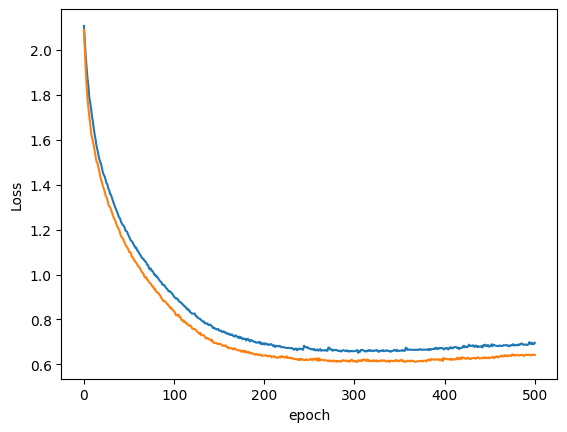

In [63]:
epochs = 501
losses = []
acc_lst = []
metric = MulticlassAccuracy(num_classes = 7)
#([1],[128,64]):#
#run training
for i in ([101,51],[128,64]):##([101,51,25],[51,101,31],[128,64],[128,32],[101,51],[35,25,19],[101],[101,51],[51,101,31]):
    #([512, 128],[1]):
    #([512, 128], [128,64,32], [512]):
    #([101,51,25,12],[101,51,25],[51,101,31],[128,64],[512,128,64,32],[128,32],[101,51], [35,25,19],[101],[101,51],[51],[21],[51,101,31]):
    losses = []
    acc_lst = []
    model = Model_Num(n_cont = conts.shape[1], 
                         out_sz = len(y.unique()), 
                         layers = i,
                         p = 0.5)
    model.train()
    train_model(model, con_train, y_train)
#     train_model(model, cats, conts, y)
    
    model.eval()
    with torch.no_grad():
        y_val = model(con_valid)
        loss = criterion(y_val, y_valid)
    y_val_out = [x.argmax().item() for x in y_val]
    
    print(str(i) + " ----")
    print(accuracy_score(y_valid,y_val_out))
    print("-------------")
    plt.plot(range(epochs), [x.item() for x in losses])
    plt.ylabel('Loss')
    plt.xlabel('epoch');

In [64]:
y_val

tensor([[-1.3763, -0.1259,  1.2051,  ..., -2.5921,  0.6615,  1.9474],
        [-1.1494, -0.2443,  1.4693,  ..., -2.0256,  0.3961,  1.5546],
        [ 3.0829,  1.5136, -0.7665,  ..., -1.5957, -0.7275, -0.3497],
        ...,
        [-1.3846, -2.3617,  2.0899,  ...,  0.7978, -1.7510, -0.4024],
        [-2.1703, -3.2665,  4.1372,  ..., -1.5743, -2.0927,  0.8535],
        [ 3.3755,  2.0891, -1.3639,  ..., -1.2636, -0.2496, -0.8697]])

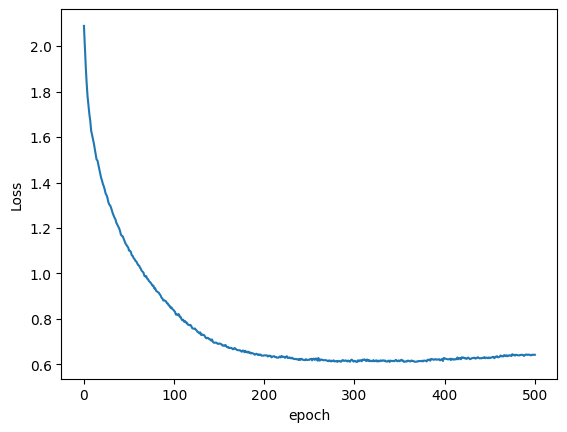

In [65]:
plt.plot(range(epochs), [x.item() for x in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

# Validate the model

In [66]:
model.eval()
with torch.no_grad():
    y_val = model(con_valid)
    loss = criterion(y_val, y_valid)

In [67]:
y_val_out = [x.argmax().item() for x in y_val]

In [68]:
len(y_val_out)

4152

<Axes: >

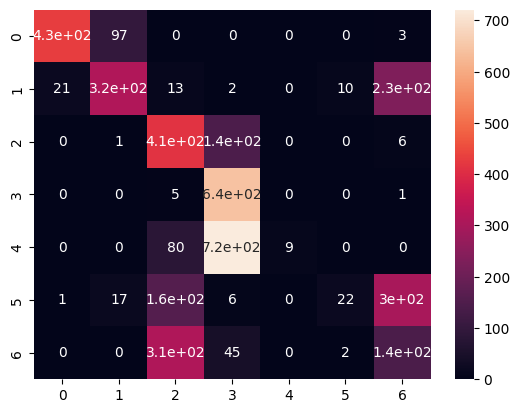

In [69]:
sns.heatmap(data=confusion_matrix(y_valid,y_val_out),annot=True)

In [70]:
accuracy_score(y_valid,y_val_out)

0.4754335260115607

# Retrain with all data with model 

In [71]:
#reset model
#emb_szs = emb_szs,
model_final = Model_Num(n_cont = conts.shape[1], 
                     out_sz = len(y.unique()), 
                     layers = [128, 64],
                     p = 0.5)

In [72]:
model_final

Model_Num(
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [73]:
criterion = nn.CrossEntropyLoss() # Classification
optimizer = torch.optim.Adam(model_final.parameters(),lr=0.0001,weight_decay=0.1)

In [74]:
epochs = 301
losses = []
acc_lst = []
metric = MulticlassAccuracy(num_classes = 7)
#run training
train_model(model_final,conts, y)

epoch:   1 | loss: 2.24043226
epoch: 101 | loss: 0.85208970
epoch: 201 | loss: 0.63857198
epoch: 301 | loss: 0.60535353
Training took 0.15702155033747356 minutes


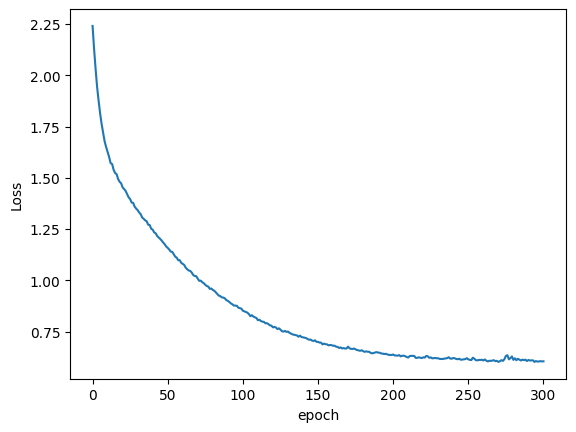

In [75]:
plt.plot(range(epochs), [x.item() for x in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

In [76]:
#cat_cols,cont_cols

# Test Data

In [77]:
df_test['BMI'] = df_test['Weight'] /(df_test['Height']**2)

In [78]:
ids = df_test['id']
df_test = df_test.drop(['id'], axis=1)
df_test = pd.get_dummies(df_test, drop_first=True)



In [79]:
cont_cols

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'NObeyesdad'],
      dtype='object')

In [80]:
# for cat in cat_cols:
#     df_test[cat] = df_test[cat].astype('category')

# Convert to numpy array the tensor for NN
# test_cats = np.stack([df_test[col].cat.codes.values for col in cat_cols],axis=1)
# test_cats = torch.tensor(test_cats, dtype=torch.int64)
# Convert to numpy array for NN
test_conts = np.stack([df_test[col].values for col in cont_cols[:-1]],axis=1)
test_conts = torch.tensor(test_conts, dtype=torch.float)
test_conts = F.normalize(test_conts)

In [81]:
conts

tensor([[0.4096, 0.0290, 0.8379,  ..., 0.0186, 0.0000, 0.3443],
        [0.2436, 0.0182, 0.9080,  ..., 0.0111, 0.0000, 0.3376],
        [0.1568, 0.0128, 0.9368,  ..., 0.0074, 0.0000, 0.3099],
        ...,
        [0.4156, 0.0301, 0.8311,  ..., 0.0198, 0.0000, 0.3597],
        [0.2172, 0.0120, 0.9226,  ..., 0.0070, 0.0000, 0.3161],
        [0.3293, 0.0177, 0.8982,  ..., 0.0000, 0.0000, 0.2867]])

In [82]:
test_conts

tensor([[0.2090, 0.0144, 0.9375,  ..., 0.0078, 0.0000, 0.2744],
        [0.2836, 0.0216, 0.8912,  ..., 0.0135, 0.0000, 0.3481],
        [0.2132, 0.0135, 0.9152,  ..., 0.0082, 0.0000, 0.3389],
        ...,
        [0.4307, 0.0298, 0.8332,  ..., 0.0188, 0.0000, 0.3314],
        [0.3454, 0.0266, 0.8717,  ..., 0.0164, 0.0000, 0.3322],
        [0.2048, 0.0140, 0.9354,  ..., 0.0077, 0.0000, 0.2848]])

In [83]:
len(conts[1]),len(test_conts[1])

(23, 23)

In [84]:
model_final.eval()
with torch.no_grad():
    y_val_final = model_final(test_conts)

In [85]:
final_out = [x.argmax().item() for x in y_val_final]

In [86]:

pandas_tensor = pd.DataFrame(final_out, columns=['NObeyesdad'])

output_df = pd.concat([ids,pandas_tensor],axis=1)

output_df['NObeyesdad'] = output_df['NObeyesdad'].map(target_map_rev)
# output_df['SK_NObeyesdad'] = output_df['SK_NObeyesdad'].map(target_map_rev)
# output_df['match'] = output_df['NObeyesdad'] == output_df['SK_NObeyesdad']
output_df

,id,NObeyesdad
0,20758,Overweight_Level_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_I
3,20761,Overweight_Level_I
4,20762,Obesity_Type_I
...,...,...
13835,34593,Overweight_Level_I
13836,34594,Overweight_Level_I
13837,34595,Obesity_Type_II
13838,34596,Obesity_Type_II


In [87]:
output_df.to_csv('/kaggle/working/submission.csv', index=False)

In [88]:
# output_df,output_df_sk